In [7]:
import graphviz
import numpy as np
import collections
import math
import random

In [8]:
def nodes_edges(root):
    nodes = []
    edges = []
    
    q = collections.deque()
    q.append(root)
    visited = set()
    
    while q:
        curr = q.popleft()
        nodes.append(curr)
        
        for child in curr._prev:
            edges.append((child, curr))
            if child not in visited:
                q.append(child)
                visited.add(child)   
    return nodes, edges

def build_graph(node):
    dot = graphviz.Digraph(format="svg", graph_attr={'rankdir': 'LR'})
    
    nodes, edges = nodes_edges(node)
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label=f"{{{n.label} | data = {n.data} | grad = {n.grad}}}", shape="record")
        
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)      
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot
    

In [90]:
class Value:
    # need to make a scalar

    def __init__(self, data, _children=(), op=None, label=None):
        self.data = data
        self._prev = set(_children)
        self._op = op
        self._backward = lambda: None
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):
        other = Value(other, label=other) if not isinstance(other, Value) else other
        
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __add__(self, other):
        other = Value(other, label=other) if not isinstance(other, Value) else other
        
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, exponent):   
        out = Value(self.data**exponent, (self,), f"^{exponent}")
        
        def _backward():
            self.grad += (exponent * (self.data ** (exponent - 1))) * out.grad
        
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * (other ** (-1))
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __rsub__(self, other):
        return other + (-self)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "e")
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
        
    
    def backward(self):
        nodes = []
        visited = set()
        def topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo(child)
                nodes.append(v)
        topo(self)
        self.grad = 1.0
        
        for n in reversed(nodes):
            n._backward()
    

In [91]:
a = Value(1.5, label="a")
b = Value(2.5, label="b")
c = a + b
d = Value(0.5, label="d")
e = c * d
e.label = "e"
c.label = "c"
o = e.tanh(); o.label = "o"
o.backward()
o

Value(0.9640275800758169)

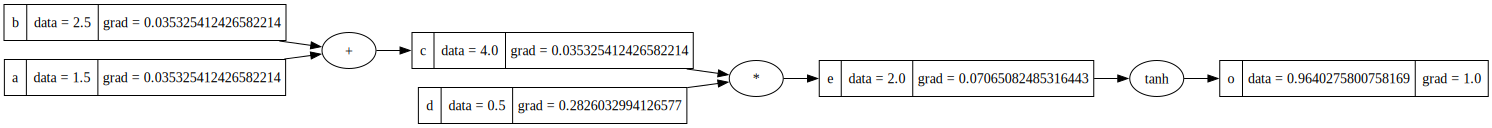

In [92]:
build_graph(o)

In [142]:
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
            
class Neuron(Module):
    
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((x_i*w_i for x_i, w_i in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        outs = []
        for n in self.neurons:
            outs.extend(n.parameters())
        return outs

class MLP(Module):
    
    def __init__(self, num_inputs, num_outputs):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x
    
    def parameters(self):
        outs = []
        for layer in self.layers:
            outs.extend(layer.parameters())
        return outs
    

In [158]:
n = MLP(3, [4,4,1])
n(x)

Value(0.13921391525601806)

In [159]:
xs = [[2.0, 3.0, -1.0],
     [2.5, 3.0, -4.0],
     [1.0, 3.0, -1.3],
     [0.5, -1.0, -1.0],
    ]
ys = [1.0, -1.0, 1.0, -1.0]
     
ypred = [n(x) for x in xs]
ypred



[Value(0.13921391525601806),
 Value(0.4326813981490224),
 Value(0.3479362165324414),
 Value(0.9276095595612365)]

In [160]:
[(ygt-ypredi)**2 for ygt, ypredi in zip(ys, ypred)]

[Value(0.7409526836888736),
 Value(2.0525759886022374),
 Value(0.42518717771002723),
 Value(3.7156786141118636)]

In [161]:
loss = sum((ygt-ypredi)**2 for ygt, ypredi in zip(ys, ypred))
loss

Value(6.9343944641130015)

In [162]:
# Gradient Descent
for i in range(20):
    ypred = [n(x) for x in xs]
    
    loss = sum((ygt-ypredi)**2 for ygt, ypredi in zip(ys, ypred))
    
    n.zero_grad()
    
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    
    print(i, loss.data)

0 6.9343944641130015
1 5.433402856080233
2 6.368756645271832
3 6.372180146065057
4 4.08068327930243
5 3.336956669468207
6 2.712397551889686
7 3.022732303199776
8 3.00696485770484
9 0.8460002398105235
10 0.3581531654782175
11 0.28081836559079254
12 0.22861628896813652
13 0.19142624403598446
14 0.1638160750314732
15 0.14263497220726826
16 0.12594700945160264
17 0.1125059394704705
18 0.10147781840585941
19 0.09228604821801194
20 0.08452064650657048
21 0.07788295546323538
22 0.07215076429218918
23 0.0671556356771994
24 0.06276776968011008
25 0.05888565860143543
26 0.05542886597289097
27 0.05233288998383657
28 0.04954544667108317
29 0.04702373840817593
30 0.04473241792065986
31 0.04264205097107546
32 0.04072794171000189
33 0.03896922526647602
34 0.03734815966026225
35 0.035849568055778075
36 0.03446039559999603
37 0.033169354441219226
38 0.0319666372253236
39 0.030843684219516544
40 0.02979299276744756
41 0.028807960407860544
42 0.027882754951263
43 0.027012206287130507
44 0.026191715816783